In [0]:
import keras
import sklearn
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM 

In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials 
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
df = drive.CreateFile({'id':'1rAuL77nhjhZnWhGsDqujZK7mOzmYVE63'})
df.GetContentFile('Alcohol_Sales.csv')
df = pd.read_csv("Alcohol_Sales.csv", index_col = "DATE", parse_dates = True)

In [85]:
df.head()

,S4248SM144NCEN
DATE,
1992-01-01,3459
1992-02-01,3458
1992-03-01,4002
1992-04-01,4564
1992-05-01,4221


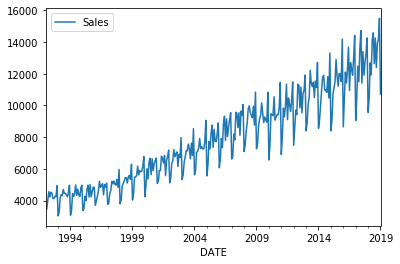

In [86]:
df.columns = ["Sales"]
df.plot()

In [0]:
results = seasonal_decompose(df["Sales"])

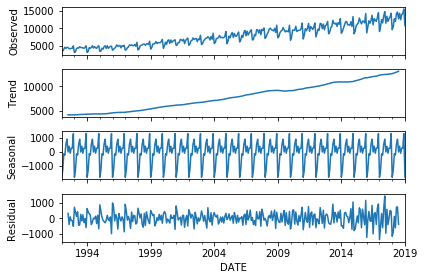

In [88]:
results.plot();

In [89]:
len(df)

325

In [0]:
train = df.iloc[:313]
test = df.iloc[313:]

In [0]:
scalar = MinMaxScaler()

In [92]:
scalar.fit(train)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [0]:
scaled_train = scalar.transform(train)

In [0]:
scaled_train = scalar.transform(train)
scaled_test = scalar.transform(test)

In [0]:
n_input = 12
n_features = 1

train_generator = TimeseriesGenerator(scaled_train,scaled_train, length=n_input, batch_size=2)

In [0]:
model = Sequential()
model.add(LSTM(150, activation = "relu", input_shape = (n_input,n_features)))
model.add(Dense(1))
model.compile(optimizer = "adam",loss="mse")

In [97]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 150)               91200     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 151       
Total params: 91,351
Trainable params: 91,351
Non-trainable params: 0
_________________________________________________________________


In [98]:
model.fit_generator(train_generator, epochs=25)

Epoch 1/25
151/151 [==============================] - 3s 21ms/step - loss: 0.0218
Epoch 2/25
151/151 [==============================] - 2s 16ms/step - loss: 0.0121
Epoch 3/25
151/151 [==============================] - 2s 16ms/step - loss: 0.0098
Epoch 4/25
151/151 [==============================] - 2s 16ms/step - loss: 0.0097
Epoch 5/25
151/151 [==============================] - 2s 16ms/step - loss: 0.0082
Epoch 6/25
151/151 [==============================] - 2s 16ms/step - loss: 0.0085
Epoch 7/25
151/151 [==============================] - 2s 16ms/step - loss: 0.0093
Epoch 8/25
151/151 [==============================] - 2s 16ms/step - loss: 0.0108
Epoch 9/25
151/151 [==============================] - 2s 16ms/step - loss: 0.0069
Epoch 10/25
151/151 [==============================] - 2s 16ms/step - loss: 0.0059
Epoch 11/25
151/151 [==============================] - 2s 16ms/step - loss: 0.0053
Epoch 12/25
151/151 [==============================] - 2s 16ms/step - loss: 0.0041
Epoch 13/25
1

In [99]:
model.history.history.keys()

dict_keys(['loss'])

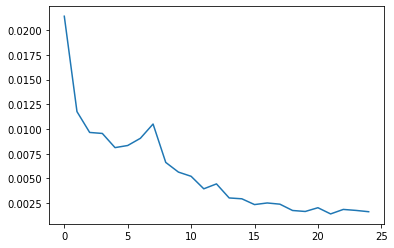

In [100]:
myloss=model.history.history["loss"]
plt.plot(range(len(model.history.history["loss"])),model.history.history["loss"])

In [101]:
first_eval_batch = scaled_train[-12:]
first_eval_batch

array([[0.63432772],
       [0.80776135],
       [0.72313873],
       [0.89870929],
       [1.        ],
       [0.71672793],
       [0.88648602],
       [0.75869732],
       [0.82742115],
       [0.87443371],
       [0.96025301],
       [0.5584238 ]])

In [0]:
first_eval_batch = first_eval_batch.reshape((1,n_input,n_features))

In [106]:
model.predict(first_eval_batch)

array([[0.6791419]], dtype=float32)

Forecasting Using RNN

In [0]:
test_predictions = []
first_eval_batch=scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1,n_input,n_features))

for i in range(len(test)):
  current_pred = model.predict(current_batch)[0]
  test_predictions.append(current_pred)
  current_batch=np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [110]:
test_predictions

[array([0.6791419], dtype=float32),
 array([0.828918], dtype=float32),
 array([0.76091045], dtype=float32),
 array([0.9219508], dtype=float32),
 array([1.006674], dtype=float32),
 array([0.7601684], dtype=float32),
 array([0.9112955], dtype=float32),
 array([0.7956412], dtype=float32),
 array([0.85871506], dtype=float32),
 array([0.9004273], dtype=float32),
 array([0.9694544], dtype=float32),
 array([0.615531], dtype=float32)]

In [0]:
true_predictions = scalar.inverse_transform(test_predictions)

In [116]:
test["Predictions"] = true_predictions

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


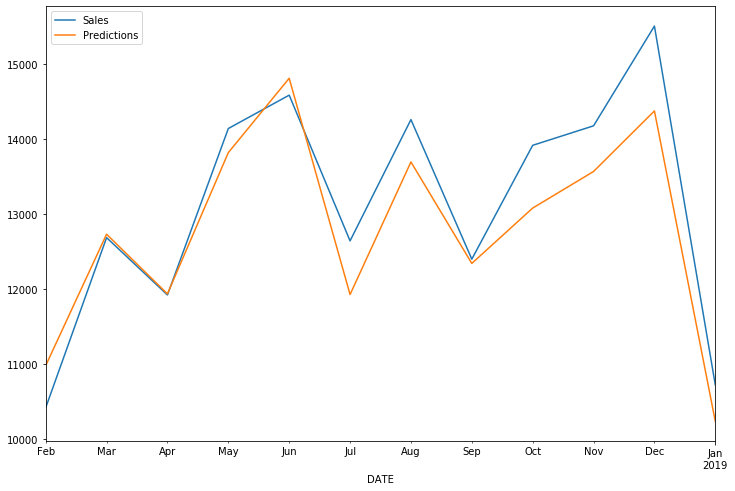

In [118]:
test.plot(figsize = (12,8))

In [115]:
test

,Sales,Predictions
DATE,,
2018-02-01,10415,[0.6791419]
2018-03-01,12683,[0.828918]
2018-04-01,11919,[0.76091045]
2018-05-01,14138,[0.9219508]
2018-06-01,14583,[1.006674]
2018-07-01,12640,[0.7601684]
2018-08-01,14257,[0.9112955]
2018-09-01,12396,[0.7956412]
2018-10-01,13914,[0.85871506]
